In [1]:
#libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


# Data Description

### For the Players data:  
Rows: 196  
Columns: 7
#### Variables
- **experience:**
   - Categorical variable meant to show how experienced at the game each player is
   - Unclear as to how it was collected, if it is self reported it may not be a reliable skill level indicator
- **subscribe**
    - Categorical variable reporting whether a player is subscribed
- **hashedEmail**
    - Categorical variable containing each players hashed email
- **played_hours**
    - double containing the number of hours each player has played
- **name**
    - Categorical variable containing each players first name
    - likely self reported 
- **gender**
    - categorical variable containing players gender
    - includes "Male", "Female", various nonbinary identies, and "prefer not to state"
    - likely self reported
- **Age**
    - double variable giving the age of each player
    - likely self reported
#### Summary Statistics:



### For the sessions data

# Questions:  
**Broad question:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?  
**Specific question:** Can a player's average session length, total number of sessions and total played hours predict whether a player will subscribe to a game related newsletter?  
**Connection to the data:**  
I can use my data to answer my question of interest by training a knn classification model using average session length, total number of sessions and total played hours as my predictors and the subscribe variable as my response variable.  
**Wrangling Plan:**  
In order to make my model I need to:  
- Join the data sets by player id  
- Calculate the average session length and total number of sessions using the session data  
- Filter to include only relevant data  
- Tidy and normalize data as needed for knn classification



# Exploratory Data Analysis and Visualization

In [2]:
# importing the data
players_data <- read_csv("data/players.csv")
sessions_data <- read_csv("data/sessions.csv")
players_data
sessions_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [20]:
#removing any rows with na values, making name formats consistent

sessions_tidy <- sessions_data |>
na.omit() |>
mutate(hashed_email = hashedEmail, hashedEmail = NULL)

sessions_tidy

players_tidy <- players_data |>
na.omit() |>
mutate(age = Age, Age = NULL, hashed_email = hashedEmail, hashedEmail = NULL)

players_tidy

#computing summary statistics for players data and formatting for readbility
players_summary <-players_tidy |>
    summarize(
        played_hours = mean(played_hours),
        age = mean(age),   
    ) |>
    pivot_longer(1:2, names_to = "variable", values_to = "mean value")
players_summary



start_time,end_time,original_start_time,original_end_time,hashed_email
<chr>,<chr>,<dbl>,<dbl>,<chr>
30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮,⋮,⋮,⋮,⋮
28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686


experience,subscribe,played_hours,name,gender,age,hashed_email
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
Pro,TRUE,30.3,Morgan,Male,9,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
Veteran,TRUE,3.8,Christian,Male,17,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
Veteran,FALSE,0.0,Blake,Male,17,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Pascal,Male,22,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd
Amateur,FALSE,0.0,Dylan,Prefer not to say,57,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
Amateur,FALSE,2.3,Harlow,Male,17,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436


variable,mean value
<chr>,<dbl>
played_hours,5.904639
age,21.139175


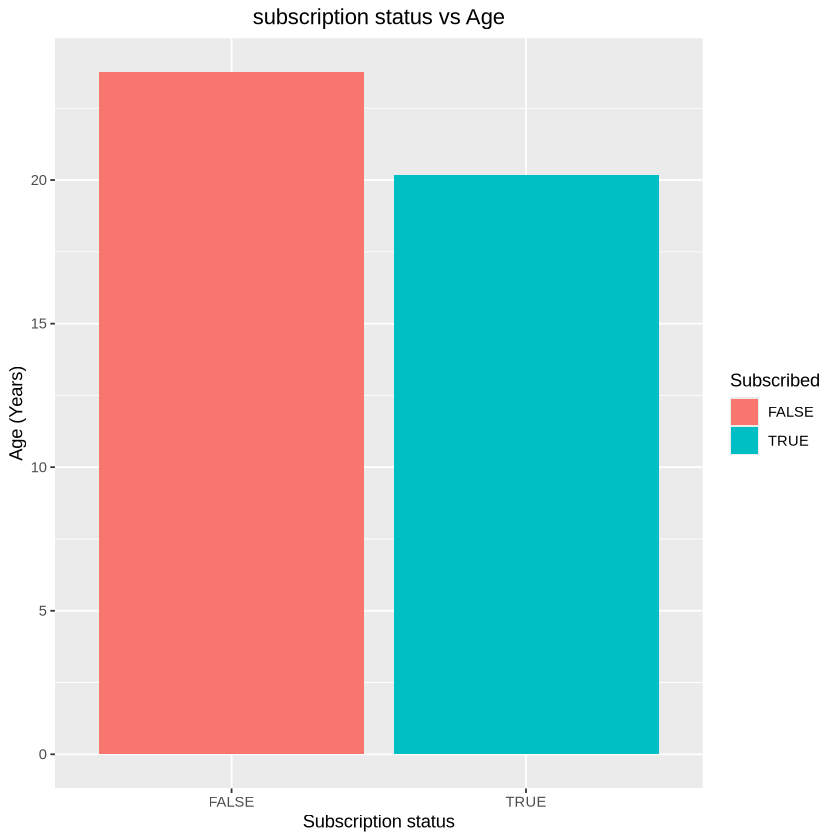

In [24]:
#plots

#time played vs age plot
playtime_age_plot <- players_tidy|>
    group_by(subscribe)|>
    summarize(mean_age = mean(age)) |>
    ggplot(aes(x = subscribe, y = mean_age, fill = subscribe)) +
    geom_bar(stat = "identity")+
    labs(x = "Subscription status", y = "Age (Years)", fill = "Subscribed")+
    ggtitle("subscription status vs Age")+
    theme(plot.title = element_text(hjust = 0.5))
playtime_age_plot

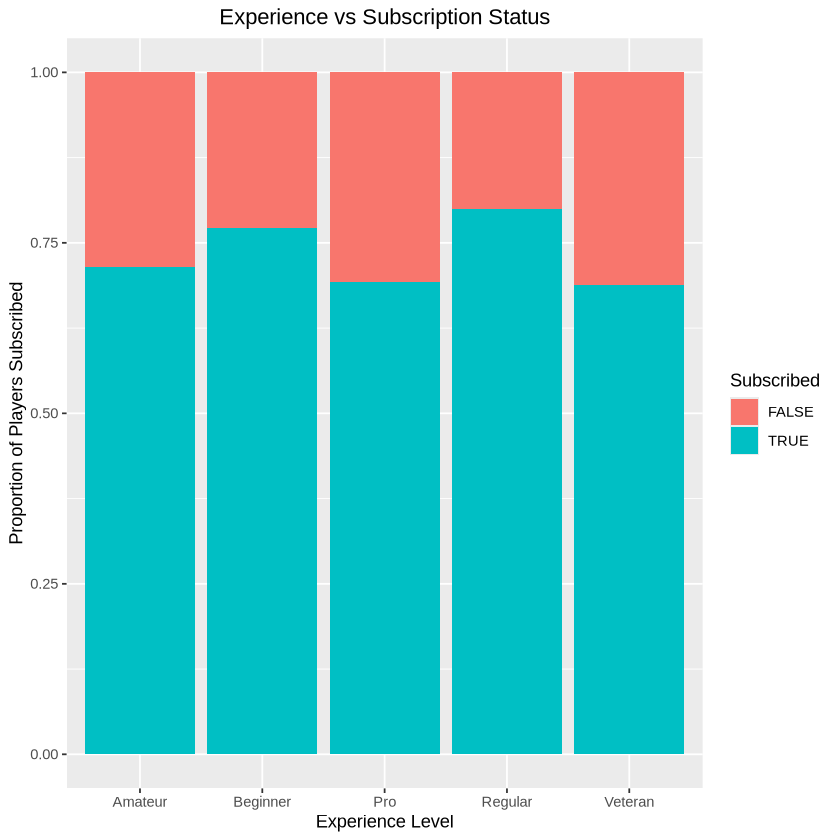

In [25]:
#subscription vs experience levvel
subscription_experience_plot <- players_tidy |> ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position="fill")+
    labs(x = "Experience Level", y = "Proportion of Players Subscribed", fill = "Subscribed")+
    ggtitle("Experience vs Subscription Status")+
    theme(plot.title = element_text(hjust = 0.5))

subscription_experience_plot

## Plot Conclusions:  
I can see from these plots that players who are not subscribed are on average a couple years older then those who are, and that the proportions of those who are subscribed to those who aren't are pretty similar across different experience levels.

In [ ]:
# Methods and plan:  
#### Method:  
I will use a knn classification model to predict whether a player will subscribe to the game related newsletter using  average session length, total played hours, and total number of sessions as my predictive variables.  
#### Why this method:   
Knn classification is the method best suited to classification that we have learned so far. With knn the data doesn't need to be any particular shape, it can classify even if relationships in data are nonlinear. 
#### Assumptions:
Knn assumes that variables are scaled and centered as needed, and that players that have similar session characteristics will have the same subscription status.
#### Limitations:  
Knn doesn't work well when classes are uneven, which could cause a problem given that the data here is fairly uneven.  
#### Model selections:  
I will tune the value of k using 5 fold cross validation and compare each model using accuracy to find the value of k that gives the best performance.   
#### Data Processing and Splitting:
I will normalize the data then split it into a training set and a test set with a 70/30 split. I will perform 5 fold cross validation on the training set to find the best model and evaluate using the test set.